# Utils Code

In [1]:
import numpy as np
import scipy.sparse as sp
import torch

def encode_onehot(labels):
    # The classes must be sorted before encoding to enable static class encoding.
    # In other words, make sure the first class always maps to index 0.
    classes = sorted(list(set(labels)))
    #print("encode_classes",classes)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    #print("labels_onehot",labels_onehot)
    return labels_onehot,classes_dict

def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

def normalize_features(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    #print("pred",preds.shape)
    correct = preds.eq(labels).double()
    #print("correct:",correct.shape)
    correct = correct.sum()
    return correct / len(labels)

# Adj and feature preparation from small fidelity dataset examples

In [2]:
import pandas as pd
df = pd.read_excel('VA_Final_Final_Sep08Ankit (Oct 8).xlsx')

In [3]:
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
df = df.drop('Unnamed: 2',axis=1)

In [5]:
df['Cogstore Mix Intent'].isna().sum()

0

In [6]:
df = df.rename({'Cogstore Mix Intent':'Label','Updated_Ankit':'Text'},axis=1)

In [7]:
df

,Label,Text
0,FundAvailability,once i sell a portion of my roth how long will...
1,PensionLetter,pension verification letter
2,HowDoImakeAstockOrMutualFundTrade,ok so i select exchange
3,FidelityHours,saturday hours
4,ResearchInvestments,what companies grow cannabis
...,...,...
27722,UpdatePersonalInfo,i have changed my cell number and need to upda...
27723,TakeOutLoan,if i pay off my 401 k loan am i immediately el...
27724,StatementsViewOnline,how do i find year end statements for 2002 2006
27725,ContactFidelity,need to speak to representative


In [8]:
for inde,row in df.iterrows():
    if row['Label']=='BoostSavings':
        print(row['Text']) 
for inde,row in df.iterrows():
    if row['Label']=='UnitizedStockFund':
        print(row['Text'])
for inde,row in df.iterrows():
    if row['Label']=='WorkplaceDisclaimer':
        print(row['Text'])
for inde,row in df.iterrows():
    if row['Label']=='NO_INTENT':
        print(row['Text'])        

i want to boost my saving
what is a unitized stock fund
workplace disclaimer
nointent


In [9]:
for inde,row in df.iterrows():
    if row['Label']=='NO_INTENT' or row['Label']=='UnitizedStockFund' or row['Label']=='WorkplaceDisclaimer' or row['Label']=='BoostSavings':
        row['Label']='Other'

In [10]:
df['Label'].value_counts()

IwantToSetUpAtransfer        1166
Contributions                1040
IwantToSetUpAwithdrawal       813
BillpayGeneral                810
RolloverGeneral               809
                             ... 
UsernameOverlap                 3
GoalboosterNextSteps            3
NetUnrealizedAppreciation       3
WithdrawalDueToDisability       2
ElectiveContribution            2
Name: Label, Length: 190, dtype: int64

# Final DataStructure

In [11]:
X=df['Text'].tolist()
y=df['Label'].tolist()

# First splitting then using Data Frame

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.3, random_state=42)


In [ ]:
# df_train = pd.DataFrame()
# df_train['Text'] = X_train
# df_train['Label'] = y_train

In [ ]:
# df =df_train

# Using Data Loader for Making Dataset Balanced

In [12]:
from torch.utils.data import Dataset, DataLoader, random_split
dataset_size = len(df)

In [13]:
class PandasDataset(Dataset):
    def __init__(self,dataframe):
        self.dataframe = dataframe
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,index):
        return self.dataframe.iloc[index]['Text'],self.dataframe.iloc[index]['Label']

In [14]:
dataset = PandasDataset(df)

In [15]:
import numpy as np 

In [16]:
dic = {}
c=0
for index, row in df.iterrows():
    if row['Label'] not in dic:
        dic[row['Label']]=c
        c+=1

In [17]:
#dic

In [18]:
lis_=[]
for index,row in df.iterrows():
    lis_.append(dic[row['Label']])

In [19]:
df['Labels']=lis_

In [20]:
df

,Label,Text,Labels
0,FundAvailability,once i sell a portion of my roth how long will...,0
1,PensionLetter,pension verification letter,1
2,HowDoImakeAstockOrMutualFundTrade,ok so i select exchange,2
3,FidelityHours,saturday hours,3
4,ResearchInvestments,what companies grow cannabis,4
...,...,...,...
27722,UpdatePersonalInfo,i have changed my cell number and need to upda...,94
27723,TakeOutLoan,if i pay off my 401 k loan am i immediately el...,51
27724,StatementsViewOnline,how do i find year end statements for 2002 2006,18
27725,ContactFidelity,need to speak to representative,15


In [21]:
#Storing all labels of data frame into a list named as y_train
y_train = [row['Labels'] for index, row in df.iterrows()]

In [22]:
#Getting count of each label
l=[]
for t in np.unique(y_train):
    c=0
    for j in y_train:
        if t == j:
            c+=1
    l.append(c)  

In [23]:
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

In [24]:
weight = 1. / class_sample_count

In [25]:

weight = 1. / class_sample_count
#samples_weight = np.array([weight[v] for k,v in dic.items()])
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

In [26]:
from torch.utils.data.sampler import WeightedRandomSampler

weighted_sampler = WeightedRandomSampler(
    weights = samples_weight,
    num_samples=5000,
    replacement=True
)

In [27]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4,sampler=weighted_sampler)

In [28]:
X=[]
Y=[]
it = iter(dataloader)
#print(it)
while True:
    try:
        x,y = next(it)
        #print(x,y)
        for item1,item2 in zip(x,y):
            #print(item1)
            X.append(item1)
            Y.append(item2)
    except StopIteration:
        print("got")
        break

got


In [29]:
dfs = pd.DataFrame()
dfs['Text']=X
dfs['Label']=Y

In [30]:
X=dfs['Text'].tolist()
y=dfs['Label'].tolist()

# Split Dataset 

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.3, random_state=42)

In [32]:
df_train = pd.DataFrame()

In [33]:
df_train['Text'] = X_train

In [34]:
df_train['Label'] = y_train

In [35]:
df_train['Label'].value_counts()

BenePerStirpes                   27
TaxesRetAcct                     27
Medicare                         27
ContactAnAdvisor                 26
CobraQuestion                    25
                                 ..
IhaveAquestionAboutStateCodes    12
RmdOverview                      11
CaresWithdrawals                 10
WithdrawalDueToDisability        10
SecureMessageSend                 9
Name: Label, Length: 190, dtype: int64

In [36]:
len(np.unique(df_train['Label']))

190

In [37]:
df_train['Label'].value_counts()

BenePerStirpes                   27
TaxesRetAcct                     27
Medicare                         27
ContactAnAdvisor                 26
CobraQuestion                    25
                                 ..
IhaveAquestionAboutStateCodes    12
RmdOverview                      11
CaresWithdrawals                 10
WithdrawalDueToDisability        10
SecureMessageSend                 9
Name: Label, Length: 190, dtype: int64

In [ ]:
#df_train.drop(df_train.index[df_train['Label'] == 'ElectiveContribution'], inplace=True)

In [ ]:


#df_train.drop(df_train.index[df_train['Label'] == 'WithdrawalDueToDisability'], inplace=True)

In [ ]:
#df_train['Label'].value_counts()

In [ ]:
# X=df_train['Text'].tolist()
# y=df_train['Label'].tolist()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.75, random_state=42)

In [ ]:
# len(X_train)

# Train Data frame Making

In [38]:
df_train = pd.DataFrame()
df_train['Text'] = X_train
df_train['Label'] = y_train

# Test Data frame Making

In [39]:
df_test = pd.DataFrame()

In [40]:
df_test['Text'] = X_test
df_test['Label'] = y_test

In [41]:
len(X_train) # Training Size

3500

In [42]:
len(X_test) # Test Size

1500

In [43]:
len(np.unique(df_test['Label'])) #Number of Unique Labels in test data frame

190

In [44]:
df_test['Label'].value_counts()

BenePerStirpes            12
TaxesRetAcct              12
Medicare                  12
TroubleWithWebsite        11
FidelityMailingAddress    11
                          ..
PasswordStopSaving         5
AcctClosure                5
FsaTypes                   5
CaresWithdrawals           4
SecureMessageSend          4
Name: Label, Length: 190, dtype: int64

In [45]:
df_test['Label'].value_counts()

BenePerStirpes            12
TaxesRetAcct              12
Medicare                  12
TroubleWithWebsite        11
FidelityMailingAddress    11
                          ..
PasswordStopSaving         5
AcctClosure                5
FsaTypes                   5
CaresWithdrawals           4
SecureMessageSend          4
Name: Label, Length: 190, dtype: int64

In [46]:
l=[]
for i in range(len(X_train)):
    l.append(1)
for i in range(len(X_train),len(X)):
    l.append(0)

In [47]:
df = pd.concat([df_train,df_test],axis=0)

In [48]:
df['train']=l

In [49]:
df['train'].value_counts()

1    3500
0    1500
Name: train, dtype: int64

In [50]:
import pandas as pd
train_sentences, train_labels, test_sentences, test_labels = [],[],[],[]

def get_dataset():
    sentences = df['Text'].tolist()
    labels = df['Label'].tolist()
    train_or_test = df['train'].tolist()

    original_train_size, original_test_size = 0, 0
    for i in range(len(train_or_test)):
        if train_or_test[i] == 1:
            train_sentences.append(sentences[i])
            train_labels.append(labels[i])
            original_train_size += 1
        elif train_or_test[i] == 0:
            test_sentences.append(sentences[i])
            test_labels.append(labels[i])
            original_test_size += 1
            
    #print("There are",len(df),"samples in",df)
    print("Original Training set size:",original_train_size)
    print("Original Test set size:",original_test_size)

In [51]:
import torch
import torch.optim as optim
import scipy.sparse as sp
import torch.nn as nn
from sklearn.metrics import classification_report

In [52]:
get_dataset()

Original Training set size: 3500
Original Test set size: 1500


In [53]:
len(np.unique(train_labels))

190

In [54]:
l_comb=train_labels+test_labels

In [ ]:
#l_comb

In [55]:
import torch
import torch.optim as optim
import scipy.sparse as sp
import torch.nn as nn
from sklearn.metrics import classification_report

In [56]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import nltk
import re

In [57]:
labels = encode_onehot(l_comb) # one hot vector for entire dataset representation

In [ ]:
#labels

In [58]:
df['Label'].value_counts()

BenePerStirpes                   39
TaxesRetAcct                     39
Medicare                         39
ContactAnAdvisor                 37
PasswordRequirements             36
                                 ..
IhaveAquestionAboutStateCodes    17
RmdOverview                      16
WithdrawalDueToDisability        15
CaresWithdrawals                 14
SecureMessageSend                13
Name: Label, Length: 190, dtype: int64

In [59]:
df

,Text,Label,train
0,how do i update reinvest dividends and capital...,DripUpdate,1
1,why did i not receive a form 5498 for,TaxFormDidntReceive,1
2,mobile access,MobilePhoneNumber,1
3,why isn't there an area marked tax forms,Taxforms,1
4,how do i re balance my portfolio,RebalancePortfolio,1
...,...,...,...
1495,where i have to upload a picture of my documen...,SecureMessageSend,0
1496,ipad version of fidelity different,MobileApp,0
1497,where do i find the options referred to in the...,FullView,0
1498,how much in taxes will it cost me to convert t...,RothConversionOverview,0


# Adj and feature preparation from dummy examples

In [60]:
import torch
import torch.optim as optim
import scipy.sparse as sp
import torch.nn as nn
from sklearn.metrics import classification_report

In [61]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import nltk
import re

In [62]:
labels,d = encode_onehot(l_comb) # one hot vector for entire dataset representation 

In [63]:
labels.shape

(5000, 190)

# Preparing Adj and feature matrix accordance with GAT

In [64]:
def preprocess_data(original_train_sentences, original_test_sentences):
    #nltk.download('stopwords')
    #stop_words = set(stopwords.words('english'))
    original_word_freq = {}  # to remove rare words
    for sentence in original_train_sentences:
        #temp = clean_str(sentence)
        temp = sentence
        word_list = temp.split()
        for word in word_list:
            if word in original_word_freq:
                original_word_freq[word] += 1
            else:
                original_word_freq[word] = 1   

    sentences = original_train_sentences + original_test_sentences
    #print(sentences)
    tokenize_sentences = []
    word_list_dict = {}
    for sentence in sentences:
        #temp = clean_str(sentence)
        temp = sentence
        word_list_temp = temp.split()
        doc_words = []
        for word in word_list_temp:
            #and word not in stop_words
            if word in original_word_freq:
                doc_words.append(word) # wo word company haijo test and train pr common word hai
                word_list_dict[word] = 1
        #print(doc_words)        
        tokenize_sentences.append(doc_words) # doc words jo list hai usko append kr rha hu
    word_list = list(word_list_dict.keys())
    #print("tokenize sentences",tokenize_sentences)
    #print(word_list)

    len_list = [len(l) for l in tokenize_sentences[:len(original_train_sentences)]]
    print("Average Length:", sum(len_list)/len(len_list))  
    return tokenize_sentences, word_list

In [65]:
tokenize_sentences, word_list = preprocess_data(train_sentences, test_sentences)
vocab_length = len(word_list)
word_id_map = {}
for i in range(vocab_length):
    word_id_map[word_list[i]] = i
#if not args.easy_copy:
print("There are :", vocab_length, "unique words in total.")

Average Length: 7.8262857142857145
There are : 1968 unique words in total.


In [66]:
from tqdm.auto import tqdm
import scipy.sparse as sp
from math import log
import numpy as np


def ordered_word_pair(a, b):
    #print(a,b)
    if a > b:
        return b, a
    else:
        return a, b

def get_adj(tokenize_sentences,train_size,word_id_map,word_list):
    window_size = 20
    total_W = 0
    word_occurrence = {}
    word_pair_occurrence = {}

    node_size = train_size + len(word_list) #11 + 3
    #print("node_size :",node_size)
    vocab_length = len(word_list)
    #print("vocab_length :",vocab_length) #11

    def update_word_and_word_pair_occurrence(q):
        #print("q :",q)
        unique_q = list(set(q))
        for i in unique_q:
            try:
                word_occurrence[i] += 1
            except:
                word_occurrence[i] = 1
        for i in range(len(unique_q)):
            for j in range(i+1, len(unique_q)):
                word1 = unique_q[i]
                word2 = unique_q[j]
                word1, word2 = ordered_word_pair(word1, word2)
                try:
                    word_pair_occurrence[(word1, word2)] += 1
                except:
                    word_pair_occurrence[(word1, word2)] = 1
                    
    for ind in range(train_size):
        #print("iteration over training set :",ind)
        words = tokenize_sentences[ind]
        #print("words :",words)
        q = []
        for i in range(min(window_size, len(words))):
            q += [word_id_map[words[i]]]
            #print("q",q)
        total_W += 1
        #print("total_W :",total_W)
        update_word_and_word_pair_occurrence(q)
        now_next_word_index = window_size
        #print(now_next_word_index)
        while now_next_word_index<len(words):
            q.pop(0)
            q += [word_id_map[words[now_next_word_index]]]
            now_next_word_index += 1
            total_W += 1
            update_word_and_word_pair_occurrence(q)
    #print(len(word_pair_occurrence))
    row = []
    col = []
    weight = []
    for word_pair in word_pair_occurrence:
        i = word_pair[0]
        j = word_pair[1]
        #print("word pair :",i,j)
        count = word_pair_occurrence[word_pair]
        word_freq_i = word_occurrence[i]
        word_freq_j = word_occurrence[j]
        pmi = log((count * total_W) / (word_freq_i * word_freq_j)) 
        if pmi <=0:
            continue
        row.append(train_size + i)
        col.append(train_size + j)
        weight.append(pmi)
        row.append(train_size + j)
        col.append(train_size + i)
        weight.append(pmi)
    #print("Rows are ",row)
    #print("Cols are ",col)


    #print("weight :",len(weight))
    #print("row:",len(row))
    #print("col:",col)
    word_doc_list = {}
    for word in word_list:
        word_doc_list[word]=[]
    #print("word_doc_list",word_doc_list)
    for i in range(train_size):
        doc_words = tokenize_sentences[i]
        #print("doc_words :",doc_words)
        unique_words = set(doc_words)
        for word in unique_words:
            exsit_list = word_doc_list[word]
            exsit_list.append(i)
            word_doc_list[word] = exsit_list
            #print("word_doc_list",word_doc_list)
    word_doc_freq = {}
    for word, doc_list in word_doc_list.items():
        word_doc_freq[word] = len(doc_list)
    #print("word_doc_freq :",word_doc_freq)
    doc_word_freq = {}

    for doc_id in range(train_size):
        words = tokenize_sentences[doc_id]
        for word in words:
            word_id = word_id_map[word]
            doc_word_str = str(doc_id) + ',' + str(word_id)
            if doc_word_str in doc_word_freq:
                doc_word_freq[doc_word_str] += 1
            else:
                doc_word_freq[doc_word_str] = 1
    #print("doc_word_freq :",doc_word_freq)

    doc_emb = np.zeros((train_size, vocab_length))

    for i in range(train_size):
        words = tokenize_sentences[i]
        doc_word_set = set()
        for word in words:
            if word in doc_word_set:
                continue
            j = word_id_map[word]
            key = str(i) + ',' + str(j)
            freq = doc_word_freq[key]
            row.append(i)
            col.append(train_size + j)
            idf = log(1.0 * train_size / word_doc_freq[word_list[j]])
            w = freq * idf
            weight.append(w)
            #print("weight :",weight)
            doc_word_set.add(word)
            doc_emb[i][j] = w/len(words)   
            #print(doc_emb)
        #print(len(doc_emb))
    #print(len(wgt))
    #wgt = weight 
    #print(weight)
    adj = sp.csr_matrix((weight, (row, col)), shape=(node_size, node_size))
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)  
    #print("adj",adj)
    return adj, doc_emb, word_doc_freq     


In [67]:
# Generate Graph
adj, doc_emb, word_doc_freq = get_adj(tokenize_sentences,len(train_sentences)+len(test_sentences),word_id_map,word_list)

In [68]:
adj.shape

(6968, 6968)

In [69]:
doc_emb.shape

(5000, 1968)

In [70]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo(), d_inv_sqrt

In [71]:
adj, norm_item = normalize_adj(adj + sp.eye(adj.shape[0]))

In [ ]:
#adj = torch.FloatTensor(np.array(adj.todense())) #dense adjecency matric needed not sparse
#features = torch.FloatTensor(np.array(features.todense()))

In [ ]:
type(adj)

In [72]:
coo=adj
row = torch.from_numpy(coo.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(coo.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

#Presuming values are floats, can use np.int64 for dtype=int8
val = torch.from_numpy(coo.data.astype(np.float64)).to(torch.float)

out = torch.sparse.FloatTensor(edge_index, val, torch.Size(coo.shape)).to_dense() 

In [73]:
out.shape

torch.Size([6968, 6968])

In [74]:
adj=out

In [75]:
adj.shape[0] - doc_emb.shape[0]

1968

In [76]:
doc_emb.shape

(5000, 1968)

In [ ]:
#13200 - 10500

In [77]:
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
# weight = Parameter(torch.FloatTensor(2740, 2740))

In [ ]:
# support1 = torch.mm(torch.Tensor(doc_emb), weight)#(10500, 2740)*(2740 * 2740) = 10500*2740
# support2 = weight #(2740 * 2740)
# support = torch.vstack((support1,support2))#10500*2740+2740*2740 = 13200*2740
# #support = dropout(support)

In [ ]:
# support.shape

In [ ]:
# Addition to previous Induct-Text GCN
# l=[]
# def Identity(size):
#     for row in range(0, size):
#         l1=[]
#         for col in range(0, size):
#             if (row == col):
#                 l1.append(1)
#             else:
#                 l1.append(0)
#         l.append((l1))
 
# # Driver Code       
# size = adj.shape[0] - doc_emb.shape[0]
# Identity(size)
    

In [ ]:
# d = doc_emb

In [ ]:
#d=np.concatenate((d, np.array(l)), axis=0)

In [ ]:
#doc_emb = d

In [78]:
features = torch.FloatTensor(doc_emb)

In [79]:
features.shape

torch.Size([5000, 1968])

In [80]:
labels = torch.LongTensor(np.where(labels)[1])

In [81]:
labels

tensor([ 47, 159, 102,  ...,  64, 135, 140])

In [ ]:
#features = support

In [82]:
features.shape,adj.shape,labels.shape

(torch.Size([5000, 1968]), torch.Size([6968, 6968]), torch.Size([5000]))

In [ ]:
len(X)

In [ ]:
len(X_train)

# Train and val

In [83]:
train_size = len(X_train)

In [84]:
def generate_train_val(train_size, train_pro=0.9):
    real_train_size = int(train_pro*train_size)
    val_size = train_size-real_train_size

    #if args.shuffle_seed!=None:
    #     np.random.seed()
    idx_train = np.random.choice(train_size, real_train_size,replace=False)
    idx_train.sort()
    idx_val = []
    pointer = 0
    for v in range(train_size):
        if pointer<len(idx_train) and idx_train[pointer] == v:
            pointer +=1
        else:
            #print(v)
            idx_val.append(v)
    return idx_train, idx_val

In [85]:
# Generate train/val dataset
idx_train, idx_val = generate_train_val(train_size)

In [86]:
#Pre-defining train test split for dummy data
#idx_train = list(range(len(X_train)-800))
#idx_val = list(range(len(X_train)-800, len(X_train)))
idx_test = list(range(len(X_train),len(X)))
#print("index of train",idx_train)

In [87]:
idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

In [88]:
idx_test

tensor([3500, 3501, 3502,  ..., 4997, 4998, 4999])

In [89]:
features.shape[1] # Vocab size

1968

In [92]:
len(labels)

5000

In [91]:
len(idx_train)

3150

# Layer Code

In [122]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """
    print("GraphAttentionLayer")
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W) # h.shape: (N, in_features), Wh.shape: (N, out_features)#10*16
        support1 = Wh
        if self.concat:
            support2 = self.W
            support = torch.vstack((support1,support2))
            #support = self.dropout(support)
            support = F.dropout(support, self.dropout, training=self.training)
            Wh = support
        e = self._prepare_attentional_mechanism_input(Wh)
        #print("E ",e.shape)
        zero_vec = -9e15*torch.ones_like(e)
        #print("Adj shape",adj.shape)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)#10*10 * 10*16=10*16

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        # Wh.shape (N, out_feature)
        # self.a.shape (2 * out_feature, 1)
        # Wh1&2.shape (N, 1)
        # e.shape (N, N)
        #print("Inside prepare_attention_mechanism_calculation",self.out_features)
        #print("a shape with out feature self.a[:self.out_features, :]",self.a[:self.out_features, :].shape)
        #print("a shape with self.a[self.out_features:, :]",self.a[self.out_features:, :].shape)
        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :])
        # broadcast add
        e = Wh1 + Wh2.T
        return self.leakyrelu(e)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


GraphAttentionLayer


# Model Code

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout
        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)
        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)
        self.nheads=nheads

    def forward(self, x, adj):
       
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        #print("Adding x ",x.shape)
        self.hid = x
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)

# Initialize the model code

In [124]:
from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

random.seed(72)
np.random.seed(72)
torch.manual_seed(72)
print("GAT CALL")
model = GAT(nfeat=features.shape[1], 
                nhid=128, 
                nclass=int(labels.max()) + 1, 
                dropout=0.1, 
                nheads=12, 
                alpha=0.2)
optimizer = optim.Adam(model.parameters(), 
                       lr=0.002, 
                       weight_decay=0)


features, adj, labels = Variable(features), Variable(torch.FloatTensor(adj)), Variable(labels)

GAT CALL


# Train Dummy Dataset

In [125]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
#from utils import cal_accuracy
val_losses = []
train_losses = []
val_loss = []
def train(epoch):
    t = time.time()
    #print("model train")
    model.train()
    optimizer.zero_grad()
    print("model call",features.shape,adj.shape)
    output = model(features, adj)
    #print("output",output)
    #print("loss calculation")
    #print("output[idx_train]",output[idx_train],labels[idx_train])
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    val_loss.append(loss_val.item())
    acc_val = accuracy(output[idx_val], labels[idx_val])
    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.data.item()),
          'acc_train: {:.4f}'.format(acc_train.data.item()),
          'loss_val: {:.4f}'.format(loss_val.data.item()),
          'acc_val: {:.4f}'.format(acc_val.data.item()),
          'time: {:.4f}s'.format(time.time() - t))

    return loss_val.data.item()


# Train model
t_total = time.time()
loss_values = []
# bad_counter = 0
# best = 10 + 1
# best_epoch = 0
for epoch in range(200):
    loss_values.append(train(epoch))
    if epoch > 20 and np.min(val_loss[-20:]) > np.min(val_loss[:-20]) :
            print("Early Stopping...")
            break

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0001 loss_train: 5.2481 acc_train: 0.0035 loss_val: 5.2478 acc_val: 0.0000 time: 5.7554s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0002 loss_train: 5.1843 acc_train: 0.2743 loss_val: 5.1947 acc_val: 0.2200 time: 5.7282s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0003 loss_train: 5.1209 acc_train: 0.5187 loss_val: 5.1479 acc_val: 0.3914 time: 5.7200s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0004 loss_train: 5.0508 acc_train: 0.5978 loss_val: 5.0930 acc_val: 0.4429 time: 5.7151s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0005 loss_train: 4.9840 acc_train: 0.6270 loss_val: 5.0359 acc_val: 0.4771 time: 5.7078s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0006 loss_train: 4.9189 acc_train: 0.6362 loss_val: 4.9931 acc_val: 0.4714 time: 5.7266s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968

Epoch: 0053 loss_train: 1.2970 acc_train: 0.7737 loss_val: 2.2829 acc_val: 0.6200 time: 5.7287s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0054 loss_train: 1.2261 acc_train: 0.7683 loss_val: 2.2457 acc_val: 0.6229 time: 5.7404s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0055 loss_train: 1.2236 acc_train: 0.7759 loss_val: 2.1070 acc_val: 0.6200 time: 5.7379s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0056 loss_train: 1.1919 acc_train: 0.7844 loss_val: 2.0435 acc_val: 0.6257 time: 5.7296s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0057 loss_train: 1.1572 acc_train: 0.7822 loss_val: 2.1668 acc_val: 0.6171 time: 5.9712s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0058 loss_train: 1.0897 acc_train: 0.7937 loss_val: 2.1047 acc_val: 0.6143 time: 6.9380s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0059 loss_train: 1.0606 acc_train: 0.8032 loss_val:

Epoch: 0106 loss_train: 0.2915 acc_train: 0.9508 loss_val: 1.5806 acc_val: 0.7200 time: 5.7365s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0107 loss_train: 0.2824 acc_train: 0.9517 loss_val: 1.5049 acc_val: 0.7314 time: 5.7333s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0108 loss_train: 0.2508 acc_train: 0.9517 loss_val: 1.6802 acc_val: 0.7343 time: 5.7295s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0109 loss_train: 0.2455 acc_train: 0.9610 loss_val: 1.5168 acc_val: 0.7086 time: 5.7326s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0110 loss_train: 0.2654 acc_train: 0.9594 loss_val: 1.5710 acc_val: 0.7314 time: 5.7284s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0111 loss_train: 0.2627 acc_train: 0.9559 loss_val: 1.5606 acc_val: 0.7057 time: 5.7451s
model call torch.Size([5000, 1968]) torch.Size([6968, 6968])
Epoch: 0112 loss_train: 0.2683 acc_train: 0.9530 loss_val:

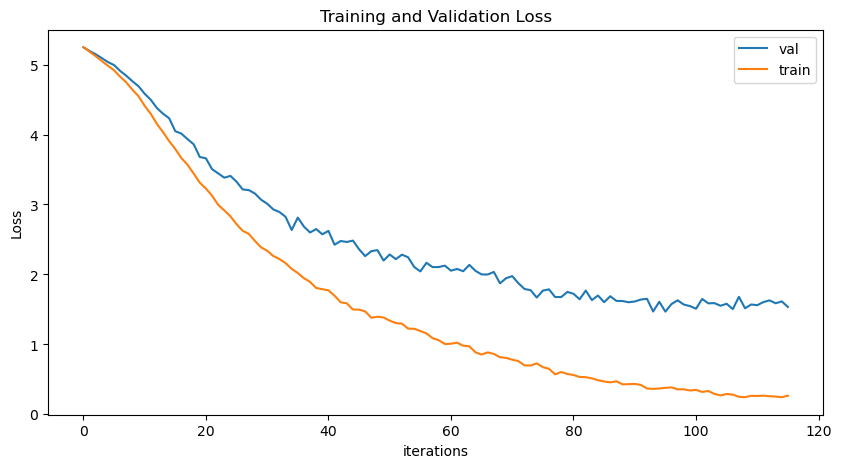

In [126]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [99]:
def get_weights_hidden_local(model,features,adj):
    model.eval()
    nheads = model.nheads
    gat_layer1_w = [model.attentions[i].W for i in range(nheads)]
    gat_layer1_a = [model.attentions[i].a for i in range(nheads)]
    gat_layer2_w = model.out_att.W
    gat_layer2_a = model.out_att.a
    layer1_hidden_weights = model.hid
    return [gat_layer1_w,gat_layer1_a,layer1_hidden_weights,gat_layer2_w,gat_layer2_a]

In [100]:
model_weight_list = get_weights_hidden_local(model,features,adj)

In [101]:
len(model_weight_list[0]),len(model_weight_list[1]),len(model_weight_list[2]),len(model_weight_list[3]),len(model_weight_list[4])

(12, 12, 6968, 2400, 380)

In [102]:
model_weight_list = get_weights_hidden_local(model,features,adj)
layer1_hidden_weights = model_weight_list[2][3:]

In [103]:
layer1_hidden_weights.shape

torch.Size([6965, 2400])

In [104]:
train_size = len(train_sentences)

In [105]:
import numpy as np
from math import log
import torch
import torch.nn.functional as F

def get_test_emb(tokenize_test_sentences, word_id_map, vocab_length, word_doc_freq, word_list, train_size):
    test_size = len(tokenize_test_sentences)
    #print("tokenize_test_sentences...",tokenize_test_sentences,len(tokenize_test_sentences))
    test_emb = [[0]*vocab_length for _ in range(test_size)]
    #print("test_emb...",test_emb)
    #print(len(test_emb))
    tokenized_test_edge = [[0]*vocab_length+[1] for _ in range(test_size)]
    #print("tokenized_test_edge...",tokenized_test_edge)
    row=[]
    col=[]
    weight=[]
    for i in range(test_size):
        tokenized_test_sample = tokenize_test_sentences[i]
        word_freq_list = [0]*vocab_length
        for word in tokenized_test_sample:
            if word in word_id_map:
                #print("word and idmap ", word,  word_id_map)
                word_freq_list[word_id_map[word]]+=1
          
        #print("tokenized_test_sample ...",tokenized_test_sample)
        for word in tokenized_test_sample:
            if word in word_id_map:
                j = word_id_map[word]
                freq = word_freq_list[j]   
                idf = log(1.0 * train_size / word_doc_freq[word_list[j]])
                w = freq * idf
                test_emb[i][j] = w/len(tokenized_test_sample)
                tokenized_test_edge[i][j] = w
                row.append(i)
                col.append(j)
                weight.append(w)
         
        #norm_item_temp = (1/norm_item[train_size:]).tolist()+[np.sqrt(np.sum(tokenized_test_edge[i]))]
        #tokenized_test_edge[i] = tokenized_test_edge[i]/np.array(norm_item_temp)

    tokenized_test_edge = np.array(tokenized_test_edge)
    #adj = sp.csr_matrix((weight, (row, col)), shape=(vocab_length+1, vocab_length+1))
    #adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)  
 
    #print("test_emb",test_emb)
    #print("tokenized_test_edge",tokenized_test_edge)
    return test_emb, tokenized_test_edge

In [106]:
#tokenize_sentences[train_size:]

In [107]:
# Generate Test input
test_emb, tokenized_test_edge = get_test_emb(tokenize_sentences[train_size:], word_id_map, vocab_length, word_doc_freq, word_list, train_size)
#len(test_emb[0]),tokenized_test_edge.shape

In [108]:
test_emb = torch.tensor(test_emb)

In [109]:
test_emb.shape

torch.Size([1500, 1968])

In [ ]:
#test_emb = torch.reshape(torch.tensor(test_emb),(3,35))
#tokenized_test_edge = torch.FloatTensor(np.array(tokenized_test_edge.todense()))
tokenized_test_edge = torch.tensor(tokenized_test_edge)
#test_emb.shape,tokenized_test_edge.shape

In [ ]:
tokenized_test_edge.shape,len(tokenized_test_edge),tokenized_test_edge

In [ ]:
test_emb.shape

In [ ]:
test_emb[0]

In [ ]:
torch.__version__

# Rachna Mam Test function implementation

In [130]:
features.shape, adj.shape

(torch.Size([5000, 1968]), torch.Size([6968, 6968]))

In [131]:
test_emb.shape,tokenized_test_edge.shape

(torch.Size([1500, 1968]), (1500, 1969))

In [129]:
model(test_emb,tokenized_test_edge)

TypeError: where() received an invalid combination of arguments - got (numpy.ndarray, Tensor, Tensor), but expected one of:
 * (Tensor condition)
 * (Tensor condition, Tensor input, Tensor other, *, Tensor out)
 * (Tensor condition, Number self, Tensor other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Tensor!, Tensor)
 * (Tensor condition, Tensor input, Number other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, Tensor, !Tensor!)
 * (Tensor condition, Number self, Number other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Tensor!, !Tensor!)


In [ ]:
model.eval()
test_result = []
for ind in range(len(test_emb)):
    print(ind)
    tokenized_test_edge_temp = tokenized_test_edge[ind]
    print(tokenized_test_edge_temp.shape)
    layer1_out = []
    for head in range(model.nheads):
        t = torch.reshape(torch.tensor(test_emb[ind]),(1,test_emb[ind].shape[0]))
        print(t.shape)
        #test_emb=test_emb[ind]
        print("model.attentions[head].W",model.attentions[head].W.shape)
        x = torch.mm(t, model.attentions[head].W)#(1*7)*(7*16)=(1*16)
        x = torch.vstack((x,model.attentions[head].W))#(1*16)+(7*16)=(8*16)
        print("model.attentions[head].a[:model.attentions[head].out_features, :]",model.attentions[head].a[:model.attentions[head].out_features, :].shape)
        Wh1 = torch.matmul(x, model.attentions[head].a[:model.attentions[head].out_features, :])#(8*16)*(16*1)
        Wh2 = torch.matmul(x, model.attentions[head].a[model.attentions[head].out_features:, :])
        e = Wh1 + Wh2.T#8*8
        print(e.shape)
        e = model.attentions[head].leakyrelu(e)
        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(tokenized_test_edge_temp > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        #x = torch.vstack((x,model.attentions[head].W))
        h_prime = torch.matmul(attention, x)
        layer1_out.append(F.elu(h_prime))
        
    #combine all the heads output
    layer1_out = torch.cat(layer1_out,dim=1)
    print("layer1_out.shape",layer1_out.shape) #8*32
    print("model.out_att.W",model.out_att.W.shape) #32*2
    
    x = torch.mm(layer1_out, model.out_att.W)
    print("x",x.shape)#8*2
    
    Wh1 = torch.matmul(x, model.out_att.a[:model.out_att.out_features, :])
    Wh2 = torch.matmul(x, model.out_att.a[model.out_att.out_features:, :])
    e = Wh1 + Wh2.T
    e = model.out_att.leakyrelu(e)
    zero_vec = -9e15*torch.ones_like(e)
    attention = torch.where(tokenized_test_edge_temp > 0, e, zero_vec)
    attention = F.softmax(attention, dim=1)
    
    h_prime = torch.matmul(attention, x)#(1*36)*(36*3)
    print(F.softmax(F.elu(h_prime),dim=1))
    predict_temp = torch.argmax(F.softmax(F.elu(h_prime),dim=1)).cpu().detach().tolist()
    test_result.append(predict_temp)

In [ ]:
model.eval()
test_result = []
for ind in range(len(test_emb)):
    print(ind)
    tokenized_test_edge_temp = tokenized_test_edge[ind]
    layer1_out = []
    for head in range(model.nheads):
        t = torch.reshape(torch.tensor(test_emb[ind]),(1,test_emb[ind].shape[0]))
        #test_emb=test_emb[ind]
        print("model.attentions[head].W",model.attentions[head].W.shape)
        #x = torch.mm(test_emb[ind], model.attentions[head].W)#(1*35)*(35*32)=(1*32)
        #x = torch.mm(t, model.attentions[head].W)#(1*35)*(35*32)=(1*32)
        x = torch.mm(t, model.attentions[head].W)#(1*7)*(7*16)=(1*16)
        #x = torch.vstack((x,model.attentions[head].W))#(1*16)+(7*16)=(8*16)
        print("model.attentions[head].a[:model.attentions[head].out_features, :]",model.attentions[head].a[:model.attentions[head].out_features, :].shape)
        Wh1 = torch.matmul(x, model.attentions[head].a[:model.attentions[head].out_features, :])#(1*32)*(35*32)
        Wh2 = torch.matmul(x, model.attentions[head].a[model.attentions[head].out_features:, :])
        e = Wh1 + Wh2.T
        e = model.attentions[head].leakyrelu(e)
        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(tokenized_test_edge_temp > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        x = torch.vstack((x,model.attentions[head].W))
        h_prime = torch.matmul(attention, x)
        layer1_out.append(F.elu(h_prime))
        
    #combine all the heads output
    layer1_out = torch.cat(layer1_out,dim=1)
    print("layer1_out.shape",layer1_out.shape) #1*384
    print("model.out_att.W",model.out_att.W.shape) #384*3
    x = torch.mm(layer1_out, model.out_att.W)#1*3
    print("x",x.shape)
    Wh1 = torch.matmul(x, model.out_att.a[:model.out_att.out_features, :])
    Wh2 = torch.matmul(x, model.out_att.a[model.out_att.out_features:, :])
    e = Wh1 + Wh2.T
    e = model.out_att.leakyrelu(e)
    zero_vec = -9e15*torch.ones_like(e)
    attention = torch.where(tokenized_test_edge_temp > 0, e, zero_vec)
    attention = F.softmax(attention, dim=1)
    layer1_hidden_weights = model.hid[len(train_sentences):] #last layer after train size
    print("layer1_hidden_weights",layer1_hidden_weights.shape)
    test_hidden_temp = torch.cat((layer1_hidden_weights,layer1_out))
    x = torch.mm(test_hidden_temp, model.out_att.W)
    print("x 2nd layer",x.shape)
    print("attention",attention.shape)
    h_prime = torch.matmul(attention, x)#(1*36)*(36*3)
    print(F.softmax(F.elu(h_prime),dim=1))
    predict_temp = torch.argmax(F.softmax(F.elu(h_prime),dim=1)).cpu().detach().tolist()
    test_result.append(predict_temp)

In [ ]:
#test_result

In [ ]:
#test_labels

In [ ]:
#Labels
#1 : 'IwantToSetUpAtransfer'
#0 : 'Contributions'
#2 : 'IwantToSetUpAwithdrawal'

In [ ]:
#l_comb=test_labels

In [ ]:
#labels = encode_onehot(l_comb)

In [ ]:
#labels,d = encode_onehot(l_comb)

In [ ]:
#labels = torch.Tensor(labels)

In [ ]:
#labels = torch.LongTensor(np.where(labels)[1])

In [ ]:
len(labels)

In [ ]:
idx_test

In [ ]:
labels[5601]

In [ ]:
labels[idx_test]

In [ ]:
print(classification_report(labels[idx_test].cpu(),test_result,digits = 4))

In [ ]:
# model.eval()
# for ind in range(len(test_emb)):

#     tokenized_test_edge_temp = tokenized_test_edge[ind]
#     layer1_out = []
#     for head in range(model.nheads):
#         test_emb = torch.reshape(test_emb[ind],(1,test_emb[ind].shape[0]))
#         #print(test_emb.shape)
#         x = torch.mm(test_emb, model.attentions[head].W)
#         x = torch.vstack((x,model.attentions[head].W))

#         Wh1 = torch.matmul(x, model.attentions[head].a[:model.attentions[head].out_features, :])
#         Wh2 = torch.matmul(x, model.attentions[head].a[model.attentions[head].out_features:, :])
#         e = Wh1 + Wh2.T
#         e = model.attentions[head].leakyrelu(e)
#         zero_vec = -9e15*torch.ones_like(e)
#         attention = torch.where(tokenized_test_edge_temp > 0, e, zero_vec)
#         attention = F.softmax(attention, dim=1)

#         h_prime = torch.matmul(attention, x)
#         layer1_out.append(F.elu(h_prime))

#     #combine all the heads output
#     layer1_out = torch.cat(layer1_out,dim=1)

#     #print("layer1_out = ",layer1_out.shape)
#     x = torch.mm(layer1_out, model.out_att.W)
#     Wh1 = torch.matmul(x, model.out_att.a[:model.out_att.out_features, :])
#     Wh2 = torch.matmul(x, model.out_att.a[model.out_att.out_features:, :])
#     e = Wh1 + Wh2.T
#     e = model.out_att.leakyrelu(e)
#     zero_vec = -9e15*torch.ones_like(e)
#     attention = torch.where(tokenized_test_edge_temp > 0, e, zero_vec)
#     attention = F.softmax(attention, dim=1)

#     h_prime = torch.matmul(attention, x)
#     print(F.softmax(F.elu(h_prime),dim=1))

# Test Function Implementation Anup

In [ ]:
df_test

In [ ]:
features.shape,adj.shape

In [ ]:
tokenized_test_edge.shape,test_emb.shape

In [ ]:
model(features, adj).shape

In [112]:
idx_test

tensor([3500, 3501, 3502,  ..., 4997, 4998, 4999])

In [ ]:
t=idx_test-3500

In [ ]:
t

In [127]:
def compute_test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    #print(output[idx_test],labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data.item()),
          "accuracy= {:.4f}".format(acc_test.data.item()))

In [128]:
compute_test()

Test set results: loss= 1.1551 accuracy= 0.7567
